<a href="https://colab.research.google.com/github/JacopoMangiavacchi/animegan2-coreml/blob/master/convert_coreml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!git clone https://github.com/jacopomangiavacchi/animegan2-coreml

Cloning into 'animegan2-coreml'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 4), reused 31 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

os.chdir(f'./animegan2-coreml')

In [18]:
from model import Generator

def load_image(path, size=None):
    image = image2tensor(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

    w, h = image.shape[-2:]
    if w != h:
        crop_size = min(w, h)
        left = (w - crop_size)//2
        right = left + crop_size
        top = (h - crop_size)//2
        bottom = top + crop_size
        image = image[:,:,left:right, top:bottom]

    if size is not None and image.shape[-1] != size:
        image = torch.nn.functional.interpolate(image, (size, size), mode="bilinear", align_corners=True)
    
    return image

def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [19]:
device = 'cpu'
torch.set_grad_enabled(False)
image_size = 512 # Can be tuned, works best when the face width is between 200~250 px

model = Generator().eval().to(device)

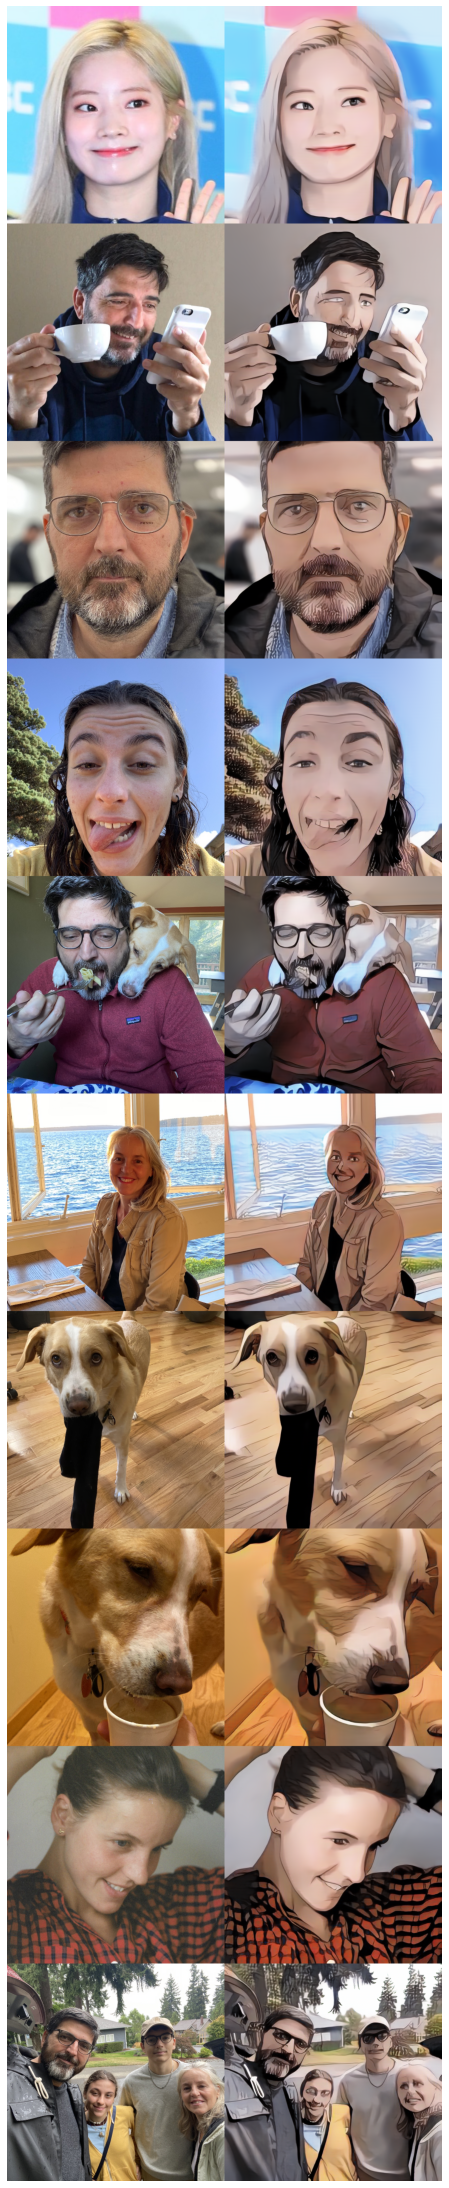

In [21]:
ckpt = torch.load(f"weights/celeba_distill.pt", map_location=device)
# ckpt = torch.load(f"weights/face_paint_512_v2.pt", map_location=device)
# ckpt = torch.load(f"weights/paprika.pt", map_location=device)
model.load_state_dict(ckpt)
    
results = []
for j in range(1,11):
    image = load_image(f"faces/{j}.jpg", image_size)
    output = model(image.to(device))

    results.append(torch.cat([image, output.cpu()], 3))
results = torch.cat(results, 2)

imshow(tensor2image(results),40)